In [69]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import math
import pickle

from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.ensemble import VotingClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('PS1B_train.csv')

In [3]:
data.head()

,C1,C2,C3,C4,C5,C6,C7,C8,Outcome
0,5,187,76,27,207,43.6,1.034,53,1
1,3,129,64,29,115,26.4,0.219,28,1
2,0,131,0,0,0,43.2,0.270,26,1
3,10,115,0,0,0,0.0,0.261,30,1
4,0,107,60,25,0,26.4,0.133,23,0


In [4]:
# for i in list(data):
#     data.hist(column=[i],bins=300, figsize=(8,6))

In [5]:
#sns.pairplot(data)

# New Approach

In [6]:
ndata = data.to_numpy()

# class separation & balancing

In [7]:
grouped = data.groupby('Outcome')

In [8]:
df_1 = grouped.get_group(1)
df_0 = grouped.get_group(0)

In [9]:
ndf_1 = df_1.to_numpy()
ndf_0 = df_0.to_numpy()

# model

In [10]:
def datagen(ndata, multiplier):
    l=[]

    for i in range((multiplier-1)*ndata.shape[0]):
        a = np.random.uniform(0,ndata.shape[0]-1,1)
        a = int(round(a[0],0))
        b = np.random.uniform(0,ndata.shape[0]-1,1)
        b = int(round(b[0],0))

        d = ndata[a] + np.random.uniform(0,1,1)*(ndata[b]-ndata[a])

        l.append(d)
    return np.array(l)

In [11]:
def balanced_gen(ndf_1,ndf_0,Total_size):
    a1 = datagen(ndf_1, int(0.5*Total_size/ndf_1.shape[0]))
    a0 = datagen(ndf_0, int(0.5*Total_size/ndf_0.shape[0]))
    
    #temp1 = np.append(ndf_1, a1, axis = 0)
    #temp2 = np.append(ndf_0, a0, axis = 0)
    up_data = np.append(a1, a0, axis = 0)
    
    up_df = pd.DataFrame(up_data)
    up_df[8] = up_df[8].round(decimals = 0)
    up_df = up_df.astype({8: int})
    
    return(up_df.sample(frac = 1))

In [12]:
df_gen_temp = balanced_gen(ndf_1,ndf_0,5000)

In [13]:
df_gen_temp

,0,1,2,3,4,5,6,7,8
264,5.610661,135.476971,72.068656,34.423667,98.552872,33.945800,0.744716,27.915991,1
3074,7.405286,134.000882,89.513657,40.351542,8.511010,31.837886,0.398863,39.567401,0
922,3.967153,174.040156,73.094888,17.744529,161.313897,34.852556,0.379179,33.291973,1
4051,5.013859,112.837595,64.712864,23.754441,98.304899,28.290689,0.399243,28.712864,0
461,3.000000,177.473946,64.947892,12.446649,109.756814,31.857816,0.485308,32.960297,1
...,...,...,...,...,...,...,...,...,...
3054,2.363180,142.397918,61.452721,15.547279,306.760719,29.289541,0.466304,23.681590,0
1898,4.999076,112.003511,65.987803,0.000000,0.000000,37.800998,0.261002,40.997228,1
3511,1.000000,7.403395,74.411300,21.028249,21.817513,28.399209,0.314835,21.359887,0
2122,8.278573,111.158938,76.417859,39.278573,128.694704,28.686968,0.632200,32.880365,1


In [14]:
df_gen_temp2 = df_gen_temp.drop(columns=[8])

In [15]:
noise = np.random.normal(0, 0.5, [df_gen_temp2.shape[0],df_gen_temp2.shape[1]])

In [16]:
df_gen_temp3 = pd.DataFrame(noise+df_gen_temp2)

In [17]:
df_gen_temp3[8] = df_gen_temp[8]

In [18]:
df_gen = df_gen_temp3.copy()

In [19]:
df_gen.head()

,0,1,2,3,4,5,6,7,8
264,5.910538,134.942837,71.830593,34.970997,98.252637,32.940072,0.952834,28.335324,1
3074,7.469624,133.758304,89.222576,40.198932,8.177660,32.670781,0.274131,39.110304,0
922,3.380155,174.887354,73.503107,17.371384,160.999024,35.413082,0.363932,33.855738,1
4051,5.249831,112.585165,65.078839,24.886263,98.520546,28.907760,0.183904,28.348033,0
461,3.056101,176.485159,65.334986,13.298831,109.580981,32.325408,-0.164004,33.456831,1


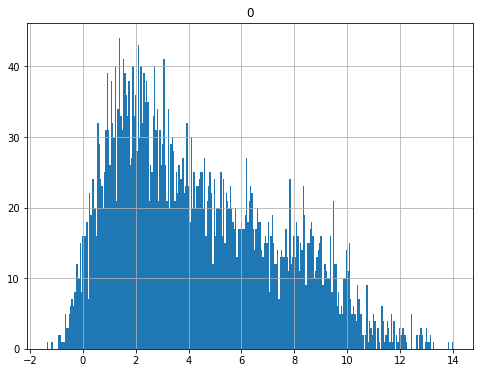

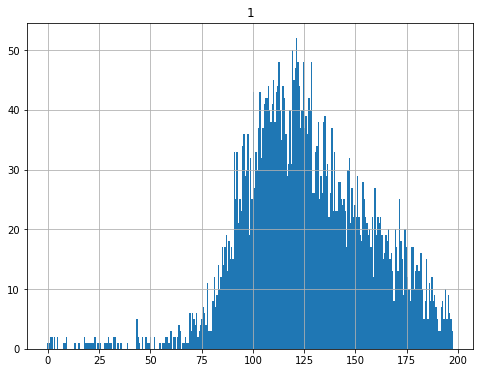

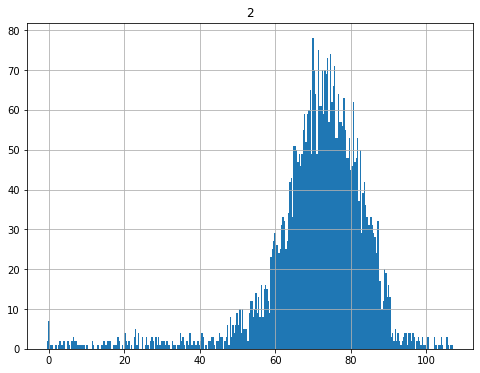

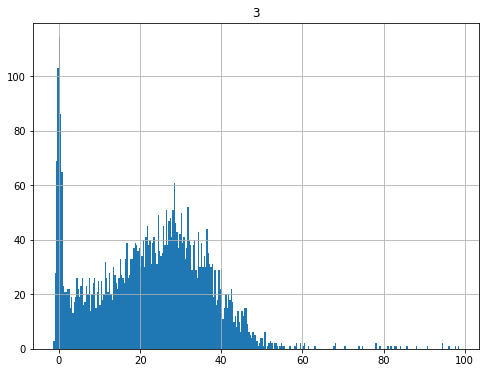

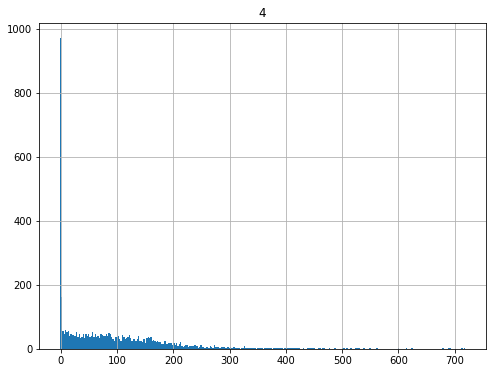

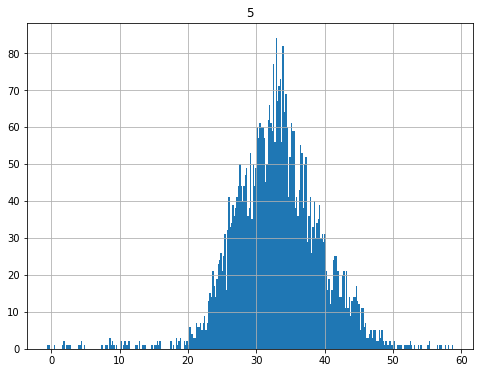

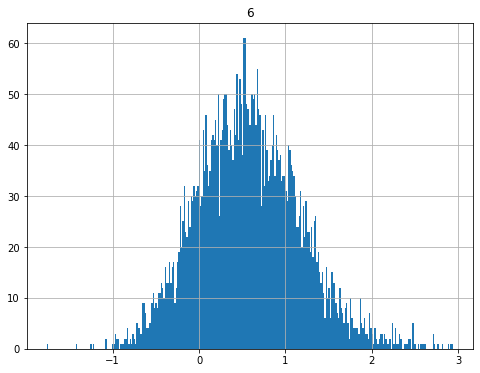

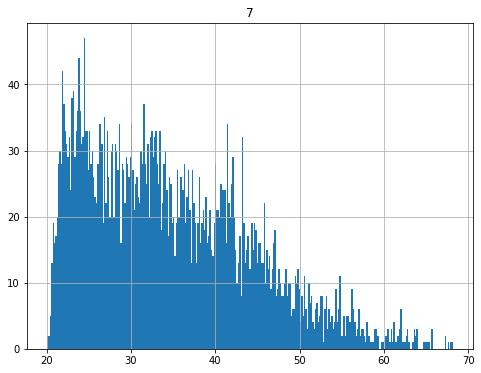

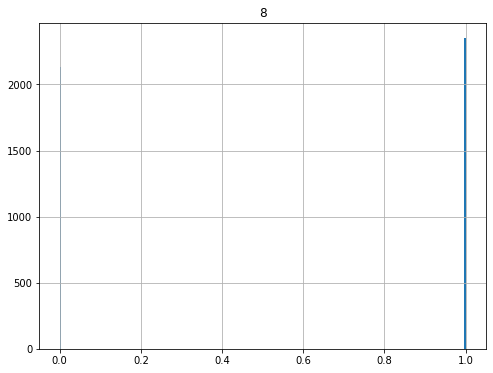

In [20]:
# for i in list(df_gen):
#     df_gen.hist(column=[i],bins=300, figsize=(8,6))

# Model (Neural Network)

In [48]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(100, 10), random_state=1)

In [49]:
clf.fit(df_gen.drop(columns=[8]),df_gen[8])

C:\Users\91979\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 10), random_state=1,
              solver='lbfgs')

In [50]:
y_pred = clf.predict(data.drop(columns=['Outcome']))

C:\Users\91979\anaconda3\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [51]:
m = confusion_matrix(data['Outcome'], y_pred)
print(m)

[[161  52]
 [ 18  76]]


In [52]:
print('precision =',m[0][0]/(m[0][0]+m[0][1]))
print('recall = ',m[0][0]/(m[0][0]+m[1][0]))

precision = 0.755868544600939
recall =  0.8994413407821229


# XGBoost

In [71]:
estimators = []
model_1 = XGBClassifier(n_estimators=1000,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      subsample=0.5,         
                      colsample_bytree=0.5,  
                      scale_pos_weight=1,
                      random_state=38)
estimators.append(('xgb', model_1))

model_2 = LGBMClassifier(n_estimators=130,
                       
                       learning_rate=0.05, 
                       objective='binary',
                       subsample=0.5,         
                       colsample_bytree=0.5, 
                       scale_pos_weight=2.47,
                       random_state=123)
estimators.append(('lgb', model_2))

model = VotingClassifier(estimators, voting='soft')

In [72]:
model_f = model.fit(df_gen.drop(columns=[8]),df_gen[8])

In [29]:
# filename = 'model_1.sav'
# pickle.dump(model_1, open(filename, 'wb'))

In [73]:
y_pred1 = model_f.predict(pd.DataFrame(data.drop(columns=['Outcome']).to_numpy()))

m1 = confusion_matrix(data['Outcome'], y_pred1)
print(m1)

[[193  20]
 [  1  93]]


In [74]:
print('precision =',m1[0][0]/(m1[0][0]+m1[0][1]))
print('recall = ',m1[0][0]/(m1[0][0]+m1[1][0]))

precision = 0.9061032863849765
recall =  0.9948453608247423


# Submission

In [78]:
x = pd.read_csv('PS1B_test.csv')
x.drop(columns=['Index'], inplace = True)

In [79]:
y_pred1 = model_f.predict(pd.DataFrame(x.to_numpy()))

In [80]:
index = [i for i in range(1,len(y_pred1)+1)]

In [81]:
df = pd.DataFrame({'Index': index, 'Target': y_pred1})

In [82]:
df.to_csv("sub_B_5.csv",index=False)